# 情感分析：使用循环神经网络
:label:`sec_sentiment_rnn`

与词相似度和类比任务一样，我们也可以将预先训练的词向量应用于情感分析。由于 :numref:`sec_sentiment`中的IMDb评论数据集不是很大，使用在大规模语料库上预训练的文本表示可以减少模型的过拟合。作为 :numref:`fig_nlp-map-sa-rnn`中所示的具体示例，我们将使用预训练的GloVe模型来表示每个词元，并将这些词元表示送入多层双向循环神经网络以获得文本序列表示，该文本序列表示将被转换为情感分析输出 :cite:`Maas.Daly.Pham.ea.2011`。对于相同的下游应用，我们稍后将考虑不同的架构选择。

![将GloVe送入基于循环神经网络的架构，用于情感分析](../img/nlp-map-sa-rnn.svg)
:label:`fig_nlp-map-sa-rnn`


In [1]:
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn, rnn
from d2l import mxnet as d2l

npx.set_np()

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## 使用循环神经网络表示单个文本

在文本分类任务（如情感分析）中，可变长度的文本序列将被转换为固定长度的类别。在下面的`BiRNN`类中，虽然文本序列的每个词元经由嵌入层（`self.embedding`）获得其单独的预训练GloVe表示，但是整个序列由双向循环神经网络（`self.encoder`）编码。更具体地说，双向长短期记忆网络在初始和最终时间步的隐状态（在最后一层）被连结起来作为文本序列的表示。然后，通过一个具有两个输出（“积极”和“消极”）的全连接层（`self.decoder`），将此单一文本表示转换为输出类别。


In [2]:
class BiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                bidirectional=True, input_size=embed_size)
        self.decoder = nn.Dense(2)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        embeddings = self.embedding(inputs.T)
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs = self.encoder(embeddings)
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        encoding = np.concatenate((outputs[0], outputs[-1]), axis=1)
        outs = self.decoder(encoding)
        return outs

让我们构造一个具有两个隐藏层的双向循环神经网络来表示单个文本以进行情感分析。


In [3]:
embed_size, num_hiddens, num_layers = 100, 100, 2
devices = d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

In [4]:
net.initialize(init.Xavier(), ctx=devices)

## 加载预训练的词向量

下面，我们为词表中的单词加载预训练的100维（需要与`embed_size`一致）的GloVe嵌入。


In [5]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

打印词表中所有词元向量的形状。


In [6]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

(49346, 100)

我们使用这些预训练的词向量来表示评论中的词元，并且在训练期间不要更新这些向量。


In [7]:
net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

## 训练和评估模型

现在我们可以训练双向循环神经网络进行情感分析。


loss 0.280, train acc 0.885, test acc 0.836
777.3 examples/sec on [gpu(0), gpu(1)]


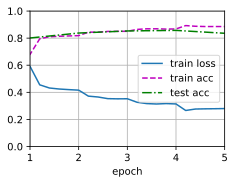

In [8]:
lr, num_epochs = 0.01, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)

我们定义以下函数来使用训练好的模型`net`预测文本序列的情感。


In [9]:
#@save
def predict_sentiment(net, vocab, sequence):
    """预测文本序列的情感"""
    sequence = np.array(vocab[sequence.split()], ctx=d2l.try_gpu())
    label = np.argmax(net(sequence.reshape(1, -1)), axis=1)
    return 'positive' if label == 1 else 'negative'

最后，让我们使用训练好的模型对两个简单的句子进行情感预测。


In [10]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [11]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## 小结

* 预训练的词向量可以表示文本序列中的各个词元。
* 双向循环神经网络可以表示文本序列。例如通过连结初始和最终时间步的隐状态，可以使用全连接的层将该单个文本表示转换为类别。

## 练习

1. 增加迭代轮数。你能提高训练和测试的准确性吗？调优其他超参数怎么样？
1. 使用较大的预训练词向量，例如300维的GloVe嵌入。它是否提高了分类精度？
1. 是否可以通过spaCy词元化来提高分类精度？你需要安装Spacy（`pip install spacy`）和英语语言包（`python -m spacy download en`）。在代码中，首先导入Spacy（`import spacy`）。然后，加载Spacy英语软件包（`spacy_en = spacy.load('en')`）。最后，定义函数`def tokenizer(text): return [tok.text for tok in spacy_en.tokenizer(text)]`并替换原来的`tokenizer`函数。请注意GloVe和spaCy中短语标记的不同形式。例如，短语标记“new york”在GloVe中的形式是“new-york”，而在spaCy词元化之后的形式是“new york”。


[Discussions](https://discuss.d2l.ai/t/5723)
